
# Module 5: Traditional Mitigation (ZNE)

**Zero-Noise Extrapolation (ZNE)** is the most popular hardware-agnostic technique and serves as the mandatory baseline for the AQC hackathon.

## 5.1 The Concept

We cannot reduce hardware noise below its physical baseline (scale $\lambda=1$). However, we *can* intentionally increase it to $\lambda = 2, 3, \dots$ and extrapolate back to $\lambda=0$.



## 5.2 Implementation: Exponential Extrapolation

Real quantum noise (depolarizing/thermal) decays exponentially: $P_{success} \propto e^{-\lambda}$. Linear fits often fail for deep circuits.
We implement an **Exponential Extrapolator** using `scipy.optimize.curve_fit`.

Running Utils-Powered ZNE Experiments...
  Scale 1.0x -> Expectation: 0.788
  Scale 2.0x -> Expectation: 0.609
  Scale 3.0x -> Expectation: 0.492
  Scale 4.0x -> Expectation: 0.359

Results:
  Noisy Baseline (1x): 0.788
  ZNE Mitigated:       0.982 (Exponential)
  Ideal Target:        1.000


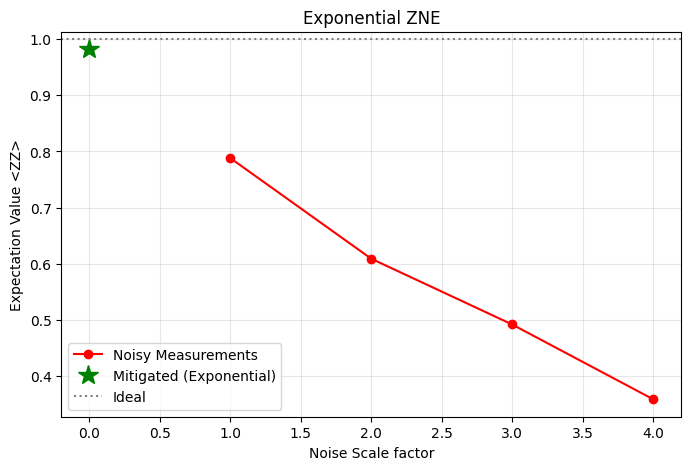

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import utils  # Shared utilities

# --- 1. ZNE Extrapolation Logic (Exponential) ---
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def zne_extrapolate(noisy_values, noise_scales=[1, 2, 3]):
    """
    Fits y = A * exp(-B * x) + C to the noisy points.
    Fallback to Linear if fit fails.
    """
    X = np.array(noise_scales)
    y = np.array(noisy_values)
    
    method = "Exponential"
    
    try:
        # Initial guess: A=1, B=0.1, C=0
        popt, _ = curve_fit(exponential_decay, X, y, p0=[1, 0.1, 0], maxfev=5000)
        # Predict at scale = 0
        mitigated = exponential_decay(0, *popt)
    except:
        # Fallback to Linear
        method = "Linear (Fallback)"
        model = LinearRegression()
        model.fit(X.reshape(-1, 1), y)
        mitigated = model.predict([[0.0]])[0]
        
    return mitigated, method

# --- 2. Run the Experiment ---
# A. Setup a Test Circuit (Bell State)
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
ideal_val = 1.0 

# B. Measure at different noise scales using UTILS
scales = [1.0, 2.0, 3.0, 4.0]
results = []

print("Running Utils-Powered ZNE Experiments...")
for s in scales:
    # Build scaled noise model from UTILS
    nm = utils.build_noise_model(scale=s)
    sim = AerSimulator(noise_model=nm)
    
    # Run
    job = sim.run(transpile(qc, sim), shots=2000)
    counts = job.result().get_counts()
    
    # Calculate <ZZ>
    shots = sum(counts.values())
    p_even = (counts.get('00', 0) + counts.get('11', 0)) / shots
    p_odd = (counts.get('01', 0) + counts.get('10', 0)) / shots
    exp_val = p_even - p_odd
    
    results.append(exp_val)
    print(f"  Scale {s}x -> Expectation: {exp_val:.3f}")

# C. Extrapolate
mitigated, method = zne_extrapolate(results, scales)

print(f"\nResults:")
print(f"  Noisy Baseline (1x): {results[0]:.3f}")
print(f"  ZNE Mitigated:       {mitigated:.3f} ({method})")
print(f"  Ideal Target:        {ideal_val:.3f}")

# D. Plot
plt.figure(figsize=(8, 5))
plt.plot(scales, results, 'ro-', label='Noisy Measurements')
plt.plot(0, mitigated, 'g*', markersize=15, label=f'Mitigated ({method})')
plt.axhline(ideal_val, color='gray', linestyle=':', label='Ideal')
plt.xlabel('Noise Scale factor')
plt.ylabel('Expectation Value <ZZ>')
plt.title('Exponential ZNE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()